In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import os
from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras import applications
from keras import layers
from keras import optimizers
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.initializers import glorot_normal
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be remo

In [14]:
class GAN:
    def __init__(self, g_model, d_model):
        self.z = latent_dim
        self.optimizer = optimizer

        self.generator = g_model
        self.discriminator = d_model

        self.train_G = train_G(self.generator, self.discriminator)
        self.loss_D, self.loss_G = [], []

    def train(self, data, batch_size=128, steps_per_epoch=100):

        for epoch in range(steps_per_epoch):
            # Select a random batch of transactions data
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_data = data[idx]

            # generate a batch of new data
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_data = self.generator.predict(noise)

            # Train D
            loss_real = self.discriminator.train_on_batch(real_data, np.ones(batch_size))
            loss_fake = self.discriminator.train_on_batch(fake_data, np.zeros(batch_size))
            self.loss_D.append(0.5 * np.add(loss_fake, loss_real))

            # Train G
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            loss_G = self.train_G.train_on_batch(noise, np.ones(batch_size))
            self.loss_G.append(loss_G)

            if (epoch + 1) * 10 % steps_per_epoch == 0:
                print('Steps (%d / %d): [Loss_D_real: %f, Loss_D_fake: %f, acc: %.2f%%] [Loss_G: %f]' %
                  (epoch+1, steps_per_epoch, loss_real[0], loss_fake[0], 100*self.loss_D[-1][1], loss_G))

        return

In [15]:
df_raw = pd.read_csv('creditcard.csv')
df_raw['Amount'] = np.log10(df_raw['Amount'].values + 1)
df_raw['Time'] = (df_raw['Time'].values/3600)
df_fraud = df_raw[df_raw['Class'] == 1]

target = 'Class'

# Divide the training data into training (80%) and test (20%)
df_train, df_test = train_test_split(df_raw, train_size=0.8, random_state=42, stratify=df_raw[target])

# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

x_train = df_train.drop(target, axis=1)
y_train = df_train[target]
x_test = df_test.drop(target, axis=1)
y_test = df_test[target]


# %% --------------------------------------- Set Seeds -----------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
weight_init = glorot_normal(seed=SEED)

# %% ---------------------------------- Hyperparameters ----------------------------------------------------------------
latent_dim = 32
data_dim = len(x_train.columns)
n_classes = len(np.unique(y_train))
optimizer = Adam(lr=0.0001, beta_1=0.1, beta_2=0.9)
trainRatio = 5

In [4]:
# Build Encoder
def encoder():
    data = Input(shape=(data_dim,))
    x = Dense(256, kernel_initializer=weight_init)(data)
    x = LeakyReLU(0.2)(x)
    #    x = layers.Dropout(0.1)(x)

    x = Dense(128, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    #    x = layers.Dropout(0.1)(x)

    x = Dense(64, kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)
    #    x = layers.Dropout(0.1)(x)

    encodered = Dense(latent_dim)(x)


    model = Model(inputs=data, outputs=encodered)
    return model

def decoder():
    noise = Input(shape=(latent_dim,))

    x = Dense(64, kernel_initializer=weight_init)(noise)
    #     x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(128, kernel_initializer=weight_init)(x)
    #     x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(256, kernel_initializer=weight_init)(x)
    #     x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # tanh is removed since we are not dealing with normalized image data
    generated = Dense(data_dim, kernel_initializer=weight_init)(x)

    generator = Model(inputs=noise, outputs=generated)
    return generator

# Build Autoencoder
def train_AE(encoder, decoder):
    feature = Input(shape=(data_dim,))
    latent = encoder(feature)
    rec_feature = decoder(latent)
    model = Model(feature, rec_feature)

    model.compile(optimizer=optimizer, loss='mae')
    return model

# Train Autoencoder
en = encoder()
de = decoder()
ae = train_AE(en, de)

ae.fit(x_train, x_train,
       epochs=30,
       batch_size=128,
       shuffle=True,
       validation_data=(x_test, x_test))


Train on 227845 samples, validate on 56962 samples
Epoch 1/30
227845/227845 [==============================] - 5s 24us/step - loss: 0.4911 - val_loss: 0.3555
Epoch 2/30
227845/227845 [==============================] - 5s 24us/step - loss: 0.3011 - val_loss: 0.2957
Epoch 3/30
227845/227845 [==============================] - 6s 25us/step - loss: 0.2364 - val_loss: 0.2083
Epoch 4/30
227845/227845 [==============================] - 6s 25us/step - loss: 0.2008 - val_loss: 0.2059
Epoch 5/30
227845/227845 [==============================] - 5s 22us/step - loss: 0.1709 - val_loss: 0.2165
Epoch 6/30
227845/227845 [==============================] - 5s 23us/step - loss: 0.1506 - val_loss: 0.1623
Epoch 7/30
227845/227845 [==============================] - 5s 23us/step - loss: 0.1391 - val_loss: 0.1694
Epoch 8/30
227845/227845 [==============================] - 5s 22us/step - loss: 0.1315 - val_loss: 0.1182
Epoch 9/30
227845/227845 [==============================] - 5s 22us/step - loss: 0.1257 - va

In [16]:
# Divide the training data into training (80%) and test (20%)
df_train, df_test = train_test_split(df_fraud, train_size=0.8, random_state=42, stratify=df_fraud[target])

# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

x_train = df_train.drop(target, axis=1)
y_train = df_train[target]
x_test = df_test.drop(target, axis=1)
y_test = df_test[target]

latent_dim = 32
data_dim = len(x_train.columns)
n_classes = len(np.unique(y_train))
optimizer = Adam(lr=0.0001, beta_1=0.1, beta_2=0.9)

In [15]:
def discriminator(encoder):

    data = Input(shape=(data_dim,))
    x = encoder(data)

    out = Dense(1, activation='sigmoid', kernel_initializer=weight_init)(x)

    model = Model(inputs=data, outputs=out)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def generator(decoder):

    noise = Input(shape=(latent_dim,))

    generated_feature = decoder(noise)
    model = Model(inputs=noise, outputs=generated_feature)

    return model


def train_G(generator, discriminator):
    # Freeze the discriminator when training generator
    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    return model

D = discriminator(en)
G = generator(de)

D.summary()
G.summary()

x_train = df_train.drop(target, axis=1)
y_train = df_train[target]
x_test = df_test.drop(target, axis=1)
y_test = df_test[target]

gan = GAN(g_model=G, d_model=D)

EPOCHS = 20
X_train = x_train.to_numpy()
for epoch in range(EPOCHS):
    print('EPOCH # ', epoch + 1, '-' * 50)
    gan.train(X_train, batch_size=128, steps_per_epoch=100)
    if (epoch+1) % 1 == 0:
        gan.generator.save('gan_pre_generator.h5')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 30)                0         
_________________________________________________________________
model_1 (Model)              (None, 32)                51168     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_2 (Model)              (None, 30)                51166     
Total params: 51,166
Trainable params:

D:\Program Files\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Steps (10 / 100): [Loss_D_real: 1.854686, Loss_D_fake: 0.322197, acc: 60.55%] [Loss_G: 1.464881]
Steps (20 / 100): [Loss_D_real: 0.689074, Loss_D_fake: 0.478994, acc: 78.52%] [Loss_G: 1.215435]
Steps (30 / 100): [Loss_D_real: 0.404704, Loss_D_fake: 0.573806, acc: 77.73%] [Loss_G: 1.022084]
Steps (40 / 100): [Loss_D_real: 0.204999, Loss_D_fake: 0.592633, acc: 79.69%] [Loss_G: 1.057282]
Steps (50 / 100): [Loss_D_real: 0.230878, Loss_D_fake: 0.564651, acc: 79.69%] [Loss_G: 1.117832]
Steps (60 / 100): [Loss_D_real: 0.313420, Loss_D_fake: 0.513291, acc: 83.59%] [Loss_G: 1.095918]
Steps (70 / 100): [Loss_D_real: 0.400042, Loss_D_fake: 0.463009, acc: 83.20%] [Loss_G: 1.316952]
Steps (80 / 100): [Loss_D_real: 0.387818, Loss_D_fake: 0.454032, acc: 83.98%] [Loss_G: 1.331147]
Steps (90 / 100): [Loss_D_real: 0.431270, Loss_D_fake: 0.528597, acc: 82.42%] [Loss_G: 1.126544]
Steps (100 / 100): [Loss_D_real: 0.431223, Loss_D_fake: 0.621392, acc: 73.83%] [Loss_G: 1.063085]
EPOCH #  2 ------------------

Steps (20 / 100): [Loss_D_real: 0.635499, Loss_D_fake: 0.701926, acc: 59.38%] [Loss_G: 0.860522]
Steps (30 / 100): [Loss_D_real: 0.656951, Loss_D_fake: 0.766852, acc: 53.91%] [Loss_G: 0.803601]
Steps (40 / 100): [Loss_D_real: 0.676729, Loss_D_fake: 0.791411, acc: 45.70%] [Loss_G: 0.840218]
Steps (50 / 100): [Loss_D_real: 0.678889, Loss_D_fake: 0.704970, acc: 55.08%] [Loss_G: 0.827372]
Steps (60 / 100): [Loss_D_real: 0.675134, Loss_D_fake: 0.669629, acc: 62.50%] [Loss_G: 0.920371]
Steps (70 / 100): [Loss_D_real: 0.692258, Loss_D_fake: 0.656257, acc: 57.03%] [Loss_G: 0.919382]
Steps (80 / 100): [Loss_D_real: 0.660077, Loss_D_fake: 0.690421, acc: 56.64%] [Loss_G: 0.894136]
Steps (90 / 100): [Loss_D_real: 0.692053, Loss_D_fake: 0.775650, acc: 49.61%] [Loss_G: 0.806598]
Steps (100 / 100): [Loss_D_real: 0.769649, Loss_D_fake: 0.799149, acc: 42.58%] [Loss_G: 0.767125]
EPOCH #  10 --------------------------------------------------
Steps (10 / 100): [Loss_D_real: 0.686837, Loss_D_fake: 0.786363

In [17]:
import matplotlib.patches as mpatches

generator = tf.keras.models.load_model('gan_pre_generator.h5')

noise = np.random.normal(0, 1, size=(1000, 32))
fake_data = generator.predict(noise)
decoded_feature = pd.DataFrame(fake_data)

def boxplot_compare(df1, df2,title):
  fig, ax = plt.subplots(figsize=(16,10))
  bp1 = df1.boxplot(color='green', showfliers=False)
  bp2 = df2.boxplot(color='purple', showfliers=False)

  patch1 = mpatches.Patch(color='green', label='Original')
  patch2 = mpatches.Patch(color='purple', label='GAN with Pre-Train')
  plt.legend(handles=[patch1, patch2], prop={'size': 16})
  ax.set_title(title)
  plt.xticks(rotation=90)
  plt.show()

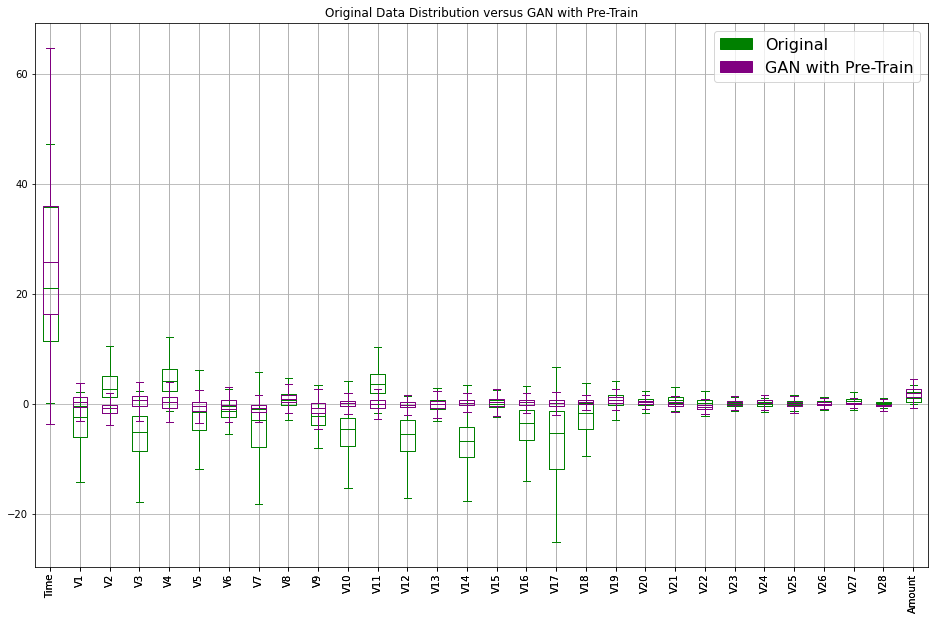

In [23]:
df = pd.read_csv('creditcard.csv')
df['Time'] = (df['Time'].values / 3600)
df['Amount'] = np.log10(df['Amount'].values + 1)

feature = df.loc[:, df.columns != 'Class']
true = df.loc[df['Class'] == 0]
fraud = df.loc[df['Class'] == 1]
true = true.loc[:, df.columns != 'Class']
fraud = fraud.loc[:, df.columns != 'Class']

boxplot_compare(fraud, df_gen_1000, 'Original Data Distribution versus GAN with Pre-Train')

In [48]:
from sklearn.model_selection import train_test_split

target = 'Class'

# Divide the training data into training (80%) and test (20%)
df_train, df_test = train_test_split(df_raw, train_size=0.8, random_state=42, stratify=df_raw[target])

# Reset the index
df_train, df_test  = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

x_train = df_train.drop(target,axis=1)
y_train = df_train[target]
x_test = df_test.drop(target,axis=1)
y_test = df_test[target]

In [49]:
def gen_data(generator, n_data):
    noise = np.random.normal(0, 1, size=(n_data, latent_dim))
    gen = generator.predict(noise)
    x_train_gen = np.concatenate((x_train, gen))
    y_gen = np.array(gen.shape[0] * [1])
    y_train_gen = np.concatenate((y_train, y_gen))
    return gen, x_train_gen, y_train_gen

In [50]:
# generate 1000 more fraud
gen_1000, x_train_gen_1000, y_train_gen_1000 = gen_data(generator, 1000)

In [51]:
df_gen_1000 = pd.DataFrame(data=gen_1000, index=None, columns=x_train.columns)
df_gen_1000.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.472897,0.269123,-0.895008,0.614541,0.310112,-0.540636,-0.202127,-0.892870,0.885713,-0.793311,...,0.245588,-0.024109,-0.614912,0.032546,0.213735,-0.103700,-0.001885,0.175866,-0.186939,1.879387
std,13.328333,1.315495,1.126839,1.394587,1.504691,1.180996,1.295504,0.933658,0.981721,1.337022,...,0.555606,0.537005,0.516557,0.523011,0.559640,0.597365,0.407212,0.339657,0.426948,0.964702
min,-2.338640,-4.212586,-5.153825,-3.832330,-4.291127,-4.835877,-4.112792,-4.009332,-2.067336,-5.832733,...,-1.849974,-1.723314,-2.298334,-2.460097,-1.730210,-2.369094,-1.319195,-0.881849,-1.729712,-1.208726
25%,16.283927,-0.615794,-1.560161,-0.270948,-0.675545,-1.282441,-1.084698,-1.509457,0.196102,-1.710471,...,-0.127216,-0.396885,-0.942913,-0.283761,-0.143362,-0.489774,-0.260062,-0.056408,-0.461286,1.207530
50%,25.090736,0.344032,-0.829663,0.631187,0.293893,-0.492750,-0.188531,-0.871711,0.895862,-0.735797,...,0.225387,-0.005805,-0.577185,0.061818,0.187524,-0.101438,0.000217,0.166223,-0.166284,1.870305
75%,34.620511,1.157255,-0.139510,1.535365,1.274335,0.238183,0.631072,-0.228222,1.594603,0.139798,...,0.584330,0.329476,-0.274662,0.401767,0.569205,0.300653,0.261738,0.413273,0.092329,2.511708
max,72.969955,4.020152,2.146783,5.107396,5.496337,2.724861,3.646155,2.861658,4.134928,2.978698,...,2.356845,1.589298,0.706371,1.304573,1.891358,1.605636,1.357738,1.377679,1.037881,4.959672


In [52]:
x_train_fraud = x_train[y_train==1]
x_train_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,...,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,23.008938,-4.707808,3.588729,-7.068378,4.592975,-3.101629,-1.387192,-5.539909,0.587920,-2.589654,...,0.358018,0.628814,0.051318,-0.062790,-0.109108,0.019602,0.047827,0.155933,0.077212,1.228674
std,13.347935,6.841390,4.309436,7.166449,2.883467,5.406586,1.864770,7.316745,6.676697,2.495584,...,1.384017,3.750615,1.457801,1.681228,0.509477,0.826820,0.467046,1.358987,0.555106,0.965996
min,1.239444,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-5.773192,-43.557242,-41.044261,-13.434066,...,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000
25%,11.500278,-5.996596,1.229209,-8.436924,2.419178,-4.741036,-2.504633,-7.765017,-0.135707,-3.828323,...,-0.181718,0.040122,-0.515338,-0.330293,-0.445282,-0.312004,-0.253693,-0.025894,-0.096541,0.301030
50%,21.393056,-2.272114,2.662472,-5.133485,4.258196,-1.522962,-1.421577,-2.926216,0.642565,-2.230097,...,0.280862,0.576441,0.073696,-0.057241,-0.060269,0.088371,-0.003464,0.394926,0.147380,1.007318
75%,35.912917,-0.410418,4.737900,-2.302626,6.390866,0.240184,-0.361122,-0.900824,1.743587,-0.825345,...,0.783528,1.204214,0.615344,0.307132,0.274014,0.441670,0.393148,0.779267,0.372389,2.028937
max,47.318889,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,11.059004,27.202839,8.361985,5.466230,0.994110,2.208209,2.745261,3.052358,1.779364,3.327741


In [53]:
# with GPU
ros = RandomOverSampler()
x, y = ros.fit_sample(x_train_gen_1000, y_train_gen_1000)


D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [54]:
# with GPU
ros = RandomOverSampler()
def XGBC_model_predit(x, y):   
    x, y = ros.fit_sample(x, y)
    clf_xgb_os = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.2, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=10, min_child_weight=2,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=800, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', validate_parameters=1)
    
    clf_xgb_os.fit(x, y)  
    y_pred_gen_os = clf_xgb_os.predict(x_test.to_numpy())
    return y_pred_gen_os

In [55]:
def check_performance(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1 score: ', f1_score(y_test, y_pred))
    print('ROC AUC score: ',  roc_auc_score(y_test, y_pred))

In [56]:
# plot confusion matrix
import scikitplot as skplt
def plot_cm(y_test, y_pred, title):
    skplt.metrics.plot_confusion_matrix(y_test, y_pred,figsize=(8,8))
    plt.title('Confusion Matrix ' + title)
    plt.show()

In [57]:
y_pred_gen_1000 = XGBC_model_predit(x_train_gen_1000, y_train_gen_1000)
check_performance(y_test, y_pred_gen_1000)

D:\Program Files\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy:  0.9995435553526912
Precision:  0.8829787234042553
Recall:  0.8469387755102041
F1 score:  0.8645833333333334
ROC AUC score:  0.9233726657517257


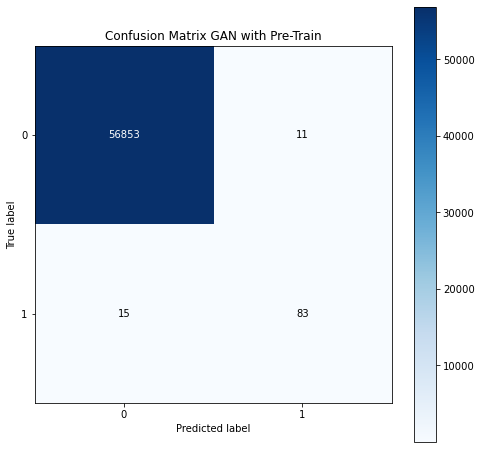

In [58]:
plot_cm(y_test, y_pred_gen_1000, 'GAN with Pre-Train')